In [1]:
import config
C = config.get_config('./config/033_augtry.yml')

config:  {'submission': False, 'batch_size': 128, 'device': 'cuda:0', 'out': '.', 'image_size': [128, 128], 'arch': 'pretrained', 'model_name': 'se_resnext50_32x4d', 'use_class_weight': False, 'datadir': PosixPath('../input/bengaliai-cv19'), 'featherdir': PosixPath('../input/bengaliaicv19feather'), 'pngdir': PosixPath('../input/bengaliai-cv19-png'), 'outdir': '../run/033_augtry.yml', 'n_epoch': 120, 'num_workers': 4, 'num_classes': [168, 11, 7], 'fold': 0, 'scheduler': 'Cosine', 'lr': 2e-05, 'aug_cutmix_p': 0.5, 'aug_cutmix_alpha': 1.0, 'aug_mixup_p': 0.5, 'aug_mixup_alpha': 0.8, 'crop_pad_size': 0, 'aug_scale': [-0.05, 0.05], 'aug_rot': 10, 'aug_shear': 5, 'aug_morph': 0.3, 'aug_auto_contrast_p': 0.5}


In [2]:
from dataset import *
from loss import *

MORPH ERODE MAX SIZE =  4
MORPH DILATE MAX SIZE =  4


In [3]:
t, v = get_trainval_dataset_png()

(200840,)
(200840, 3)
  image_id  fold
0  Train_0     3
1  Train_1     2
2  Train_2     4
3  Train_3     2
4  Train_4     1
pre-split fold loaded, valid_indices:(array([     9,     12,     20, ..., 200830, 200834, 200835]),)
train_dataset 160672 valid_dataset 40168


89
1
5
0.9606879


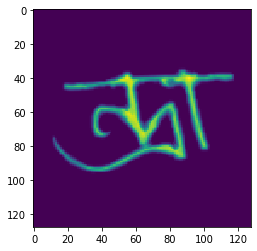

In [47]:
im, la = t[151]
#print( im.shape )
#print( la.shape )
print( la[0] )
print( la[1] )
print( la[2] )
print( im[0].max() )

import matplotlib.pyplot as plt
plt.imshow(im[0])
plt.show()

In [ ]:
np.random.uniform()

In [ ]:
p90 = np.percentile(im[0], 99.5 )
print( im[0].max())

plt.subplot(1,2,1)
plt.imshow( im[0] ) #, cmap='gray')
plt.subplot(1,2,2)
plt.imshow( np.clip( im[0] / p90, 0, 1 ) )#, cmap='gray')
plt.show()

In [ ]:
im, la = v[7]
print( la[0] )
print( la[1] )
print( la[2] )

import matplotlib.pyplot as plt
plt.imshow(im[0])
plt.show()

In [ ]:
t.image_ids[:5]

In [ ]:
v.image_ids[:5]

# GridMask

In [ ]:
from torch.utils.data.dataloader import DataLoader
dl = DataLoader(t, batch_size=1, shuffle=True)

In [ ]:
from trans import GridMask
gm = GridMask(C.image_size[0] * 0.1, C.image_size[0] * 0.4, ratio=0.6, rotate=360, mode=1)

i = 0
for x, y in dl:
    x_aug = gm(x)
    
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.imshow(x[0][0])
    plt.subplot(1,2,2)
    plt.imshow(x_aug[0][0])
    plt.title("")
    plt.show()
    
    i += 1
    if i > 10 : break

### mixup

In [ ]:
from torch.utils.data.dataloader import DataLoader
dl = DataLoader(t, batch_size=4, shuffle=True)


In [ ]:
i = 0
for x, y in dl:
    #print(y[0].shape)
    
    ## [B,3] -> [3, B]
    mix_x, mix_y1, mix_y2, mix_y3 = mixup_multi_targets(x, y[:, 0], y[:, 1], y[:, 2])
    #print(mix_x.shape)
    
    l1 = mix_y1[0]
    l2 = mix_y2[1]
    l3 = mix_y3[2]
    #print(l1.shape)
    #print(l2.shape)
    #print(l3.shape)
    #print(l1)
    
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.imshow(x[0][0])
    plt.subplot(1,2,2)
    plt.imshow(mix_x[0][0])
    plt.title("")
    plt.show()
    
    i += 1
    if i >= 2 : break

In [ ]:
BS = 2
C = 3
y_pred = torch.from_numpy( np.array( [ [0, .2, .8], [0, 0, 1] ,[0.9, 0., 0.1] ] ) )

y_onehot      = torch.from_numpy( np.array( [ [0,0,1], [0,0,1] ,[0,0,1] ] ) )
y      = torch.from_numpy( np.array( [2,2,2] ) )

#mixup_cross_entropy_loss()
y_pred

print( torch.nn.functional.cross_entropy(y_pred, y) )
print( mixup_cross_entropy_loss(y_pred, y_onehot) )

In [ ]:
print(y)

In [ ]:
y_onehot_2 = torch.from_numpy( np.array( [ [0, .2, .8], [0,0,1] ,[0.9, 0, 0.1] ] ) )

### perfect pred
print( mixup_cross_entropy_loss(y_pred, y_onehot_2) )

In [ ]:
### bad pred 1
y_pred_2 = torch.from_numpy( np.array( [ [.9, .1, .0], [0, 0.5, 0.5] ,[0.1, 0.4, 0.5] ] ) )

print( mixup_cross_entropy_loss(y_pred_2, y_onehot_2) )


In [ ]:
### bad pred 3
y_pred_3 = torch.from_numpy( np.array( [ [1./3, 1./3, 1./3], [1./3, 1./3, 1./3] ,[1./3, 1./3, 1./3] ] ) )

print( mixup_cross_entropy_loss(y_pred_3, y_onehot_2) )


In [ ]:
y_pred = y_pred_3.to('cuda:0')

y_pred